In [32]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from data_processing import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import optuna

import numpy as np
from tqdm import tqdm
import copy



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
### Load data
data_dir = "../01_Datenaufbereitung/Output/Calculated/"
all_data = load_data(data_dir)


Found 15 parquet files


Processing cells:   0%|          | 0/15 [00:00<?, ?cell/s]

Processing C01 ...


Processing cells:   7%|▋         | 1/15 [00:16<03:51, 16.55s/cell]

Processing C03 ...


Processing cells:  13%|█▎        | 2/15 [00:24<02:31, 11.66s/cell]

Processing C05 ...


Processing cells:  20%|██        | 3/15 [00:33<02:02, 10.18s/cell]

Processing C07 ...


Processing cells:  27%|██▋       | 4/15 [00:41<01:44,  9.47s/cell]

Processing C09 ...


Processing cells:  33%|███▎      | 5/15 [00:46<01:16,  7.68s/cell]

Processing C11 ...


Processing cells:  40%|████      | 6/15 [00:51<01:01,  6.89s/cell]

Processing C13 ...


Processing cells:  47%|████▋     | 7/15 [00:53<00:42,  5.29s/cell]

Processing C15 ...


Processing cells:  53%|█████▎    | 8/15 [00:56<00:31,  4.45s/cell]

Processing C17 ...


Processing cells:  60%|██████    | 9/15 [01:04<00:34,  5.81s/cell]

Processing C19 ...


Processing cells:  67%|██████▋   | 10/15 [01:13<00:32,  6.55s/cell]

Processing C21 ...


Processing cells:  73%|███████▎  | 11/15 [01:20<00:27,  6.94s/cell]

Processing C23 ...


Processing cells:  80%|████████  | 12/15 [01:29<00:22,  7.39s/cell]

Processing C25 ...


Processing cells:  87%|████████▋ | 13/15 [01:34<00:13,  6.84s/cell]

Processing C27 ...


Processing cells:  93%|█████████▎| 14/15 [01:42<00:07,  7.10s/cell]

Processing C29 ...


Processing cells: 100%|██████████| 15/15 [01:47<00:00,  7.20s/cell]


In [34]:
train_df, val_df, test_df = split_data(all_data, train=13, val=1, test=1,parts = 5)
train_scaled, val_scaled, test_scaled = scale_data(train_df, val_df, test_df)

Cell split completed:
Training set: 13 cells
Validation set: 1 cells
Test set: 1 cells
Final dataset sizes:
Training set: 48609 rows (split into 65 parts)
Validation set: 4561 rows from 1 cells
Test set: 4602 rows from 1 cells


In [ ]:
### Visualize data
# visualize_data(all_data)
# inspect_data_ranges(all_data)
# inspect_data_ranges(train_scaled)
# plot_dataset_soh(train_df, "Train")
# plot_dataset_soh(val_df, "Validation")
# plot_dataset_soh(test_df, "Test")

In [37]:
class SequenceDataset(Dataset):
    def __init__(self, df, seed_len = 36, pred_len = 1):
        self.seed_len = seed_len
        self.pred_len = pred_len
        self.data = df[["SOH_ZHU",'Current[A]', 'Voltage[V]','Temperature[°C]']].values

    def __len__(self):
        return len(self.data) - (self.seed_len + self.pred_len)

    def __getitem__(self, idx):
        # X: (batch_size, seq_len, num_features)
        x_seq = self.data[idx : idx + self.seed_len]
        # Y: (batch_size, pred_len)
        y_seq = self.data[idx + self.seed_len : idx + self.seed_len + self.pred_len, 0]

        x = torch.tensor(x_seq, dtype=torch.float32)
        y = torch.tensor(y_seq, dtype=torch.float32)
        return x, y



# Using ground truth of SOH and 3 covariances
seed_length=13
pred_length=10
batch_size=16
train_dataset = SequenceDataset(train_scaled, seed_len=seed_length, pred_len=pred_length)
val_dataset = SequenceDataset(val_scaled, seed_len=seed_length, pred_len=pred_length)
test_dataset = SequenceDataset(test_scaled, seed_len=seed_length, pred_len=pred_length)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)



In [38]:
class LSTMSOH(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int, dropout: float):
        super(LSTMSOH, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout= dropout)
        # Attention layer: project hidden state at each time step to a scalar attention weight
        # self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, dtype=x.dtype, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, dtype=x.dtype, device=x.device)
        lstm_out, _ = self.lstm(x,(h0,c0))  # lstm_out shape: (batch_size, seq_len, hidden_dim)
        
        # # # Compute attention scores and normalize them
        # attn_scores = self.attention(lstm_out)  # shape: (batch_size, seq_len, 1)
        # attn_weights = torch.softmax(attn_scores, dim=1)  # softmax over seq_len
        
        # # # Compute the context vector as the weighted sum of LSTM outputs
        # context = torch.sum(attn_weights * lstm_out, dim=1)  # shape: (batch_size, hidden_dim)
        # out = self.fc(context)  # Final prediction, shape: (batch_size, 1)
        
        out = self.fc(lstm_out[:,-1,:]) # (batch_size, hidden_dim) -> (batch_size, 1)
        
        return out.squeeze(-1) #(batch_size,)

In [39]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, patience=5):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    history = {'train_loss': [],'val_loss': [],'val_mae': [],'val_rmse': [],'val_r2': []}
    
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0
    
    target_idx = 0
    
    for epoch in range(num_epochs):
        # -----------------------------
        # 1) Training Loop (pure autoregressive)
        # -----------------------------
        model.train()
        train_losses = []
        
        for X_batch, Y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False):
            X_batch = X_batch.to(device)  # shape: (batch_size, seed_len, num_features)
            Y_batch = Y_batch.to(device)  # shape: (batch_size, pred_len)
            
            batch_size, seed_len, num_features = X_batch.shape
            pred_len = Y_batch.shape[1]
            
            # current_seq als autoregressive rolling window
            current_seq = X_batch.clone()  # (batch_size, seed_len, num_features)
            preds_steps = []
            
            for t in range(pred_len):
                # 1) Predicting the next time step with the current sequence
                pred = model(current_seq)  # (batch_size,)
                preds_steps.append(pred.unsqueeze(1))  # -> (batch_size, 1)
                
                # 2) Write pred back to current_seq's target column, ready for the next time step.
                 # exceed seed_len or no more features, only the current last frame will be kept.
                next_input = current_seq[:, -1, :].clone()
                # Replace target columns with model predictions
                next_input[:, target_idx] = pred
                
                # 3) Move the window: remove the top frame, put in a new prediction frame
                #   current_seq[:, 1:, :] -> drop the last step
                #   next_input.unsqueeze(1) -> (batch_size, 1, num_features)
                current_seq = torch.cat([current_seq[:, 1:, :], next_input.unsqueeze(1)], dim=1)
            
            preds_steps = torch.cat(preds_steps, dim=1)
            loss = criterion(preds_steps, Y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
        
        mean_train_loss = np.mean(train_losses)
        history['train_loss'].append(mean_train_loss)
        
        # -----------------------------
        # 2) Validation Loop (pure autoregressive)
        # -----------------------------
        model.eval()
        val_losses = []
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for X_val, Y_val in val_loader:
                X_val = X_val.to(device)
                Y_val = Y_val.to(device)
                batch_size, seed_len, num_features = X_val.shape
                pred_len = Y_val.shape[1]
                
                current_seq = X_val.clone()
                preds_steps = []
                
                for t in range(pred_len):
                    pred = model(current_seq)  # (batch_size,)
                    preds_steps.append(pred.unsqueeze(1))
                    
                    next_input = current_seq[:, -1, :].clone()
                    next_input[:, target_idx] = pred
                    
                    current_seq = torch.cat([current_seq[:, 1:, :], next_input.unsqueeze(1)], dim=1)
                
                preds_steps = torch.cat(preds_steps, dim=1)  # (batch_size, pred_len)
                val_loss = criterion(preds_steps, Y_val)
                val_losses.append(val_loss.item())
                
                all_preds.append(preds_steps.cpu().numpy())
                all_targets.append(Y_val.cpu().numpy())
        
        mean_val_loss = np.mean(val_losses)
        history['val_loss'].append(mean_val_loss)
        
        # Calculate overall MAE, RMSE, R2
        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)
        mae = np.mean(np.abs(all_preds - all_targets))
        rmse = np.sqrt(np.mean((all_preds - all_targets)**2))
        
        ss_res = np.sum((all_targets - all_preds)**2)
        ss_tot = np.sum((all_targets - np.mean(all_targets))**2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 1e-12 else 0.0
        
        history['val_mae'].append(mae)
        history['val_rmse'].append(rmse)
        history['val_r2'].append(r2)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {mean_train_loss:.4e} | Val Loss: {mean_val_loss:.4e} | "
              f"MAE: {mae:.4e} | RMSE: {rmse:.4e} | R2: {r2:.4f}")
        
        # -----------------------------
        # 3) Early Stopping
        # -----------------------------
        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1} because validation loss did not improve.")
                break
    
    return history, best_model_state


In [40]:
model = LSTMSOH(input_dim=4, hidden_dim=80, num_layers=5, dropout=0.5).type(torch.float32).to(device)
optimizer = optim.Adam(model.parameters(), lr= 1.4296450393279462e-05, weight_decay=0.00012)
criterion = nn.MSELoss()
history, best_state = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100, patience=15)
torch.save(best_state, "best_model.pth") 

Epoch [1/100] | Train Loss: 8.6163e-02 | Val Loss: 3.0031e-03 | MAE: 4.3685e-02 | RMSE: 5.4800e-02 | R2: -0.4388


Epoch [2/100] | Train Loss: 4.9960e-03 | Val Loss: 3.0748e-03 | MAE: 4.4127e-02 | RMSE: 5.5451e-02 | R2: -0.4732


Epoch [3/100] | Train Loss: 3.9559e-03 | Val Loss: 2.0431e-03 | MAE: 3.5931e-02 | RMSE: 4.5201e-02 | R2: 0.0211


Epoch [4/100] | Train Loss: 2.5506e-03 | Val Loss: 1.0634e-03 | MAE: 2.7894e-02 | RMSE: 3.2610e-02 | R2: 0.4905


Epoch [5/100] | Train Loss: 1.0984e-03 | Val Loss: 3.9701e-04 | MAE: 1.6824e-02 | RMSE: 1.9925e-02 | R2: 0.8098


Epoch [6/100] | Train Loss: 7.1324e-04 | Val Loss: 7.9293e-05 | MAE: 7.0892e-03 | RMSE: 8.9047e-03 | R2: 0.9620


Epoch [7/100] | Train Loss: 5.3544e-04 | Val Loss: 4.5410e-05 | MAE: 5.2540e-03 | RMSE: 6.7387e-03 | R2: 0.9782


Epoch [8/100] | Train Loss: 4.4083e-04 | Val Loss: 2.8465e-05 | MAE: 3.9848e-03 | RMSE: 5.3353e-03 | R2: 0.9864


Epoch [9/100] | Train Loss: 3.9016e-04 | Val Loss: 2.9379e-05 | MAE: 4.3157e-03 | RMSE: 5.4203e-03 | R2: 0.9859


Epoch [10/100] | Train Loss: 3.5991e-04 | Val Loss: 2.1300e-05 | MAE: 3.0219e-03 | RMSE: 4.6152e-03 | R2: 0.9898


Epoch [11/100] | Train Loss: 3.4090e-04 | Val Loss: 1.4661e-05 | MAE: 2.5204e-03 | RMSE: 3.8289e-03 | R2: 0.9930


Epoch [12/100] | Train Loss: 3.2606e-04 | Val Loss: 1.6702e-05 | MAE: 2.7924e-03 | RMSE: 4.0868e-03 | R2: 0.9920


Epoch [13/100] | Train Loss: 3.1676e-04 | Val Loss: 3.0502e-05 | MAE: 4.5819e-03 | RMSE: 5.5228e-03 | R2: 0.9854


Epoch [14/100] | Train Loss: 3.0741e-04 | Val Loss: 1.1624e-05 | MAE: 2.3865e-03 | RMSE: 3.4095e-03 | R2: 0.9944


Epoch [15/100] | Train Loss: 3.0078e-04 | Val Loss: 1.5132e-05 | MAE: 2.7479e-03 | RMSE: 3.8900e-03 | R2: 0.9927


Epoch [16/100] | Train Loss: 2.9401e-04 | Val Loss: 1.9079e-05 | MAE: 3.6297e-03 | RMSE: 4.3680e-03 | R2: 0.9909


Epoch [17/100] | Train Loss: 2.8930e-04 | Val Loss: 2.2454e-05 | MAE: 3.5115e-03 | RMSE: 4.7386e-03 | R2: 0.9892


Epoch [18/100] | Train Loss: 2.8713e-04 | Val Loss: 9.9116e-06 | MAE: 2.2792e-03 | RMSE: 3.1483e-03 | R2: 0.9953


Epoch [19/100] | Train Loss: 2.8194e-04 | Val Loss: 2.4821e-05 | MAE: 3.7538e-03 | RMSE: 4.9821e-03 | R2: 0.9881


Epoch [20/100] | Train Loss: 2.7704e-04 | Val Loss: 5.9111e-06 | MAE: 1.7479e-03 | RMSE: 2.4313e-03 | R2: 0.9972


Epoch [21/100] | Train Loss: 2.7475e-04 | Val Loss: 6.7859e-06 | MAE: 1.9117e-03 | RMSE: 2.6050e-03 | R2: 0.9967


Epoch [22/100] | Train Loss: 2.7120e-04 | Val Loss: 1.3128e-05 | MAE: 3.0704e-03 | RMSE: 3.6233e-03 | R2: 0.9937


Epoch [23/100] | Train Loss: 2.6819e-04 | Val Loss: 6.3708e-06 | MAE: 1.9079e-03 | RMSE: 2.5240e-03 | R2: 0.9969


Epoch [24/100] | Train Loss: 2.6491e-04 | Val Loss: 4.5305e-06 | MAE: 1.4596e-03 | RMSE: 2.1285e-03 | R2: 0.9978


Epoch [25/100] | Train Loss: 2.6117e-04 | Val Loss: 1.1951e-05 | MAE: 2.8068e-03 | RMSE: 3.4570e-03 | R2: 0.9943


Epoch [26/100] | Train Loss: 2.5960e-04 | Val Loss: 4.7708e-05 | MAE: 5.9760e-03 | RMSE: 6.9071e-03 | R2: 0.9771


Epoch [27/100] | Train Loss: 2.5661e-04 | Val Loss: 5.3848e-06 | MAE: 1.7462e-03 | RMSE: 2.3205e-03 | R2: 0.9974


Epoch [28/100] | Train Loss: 2.5516e-04 | Val Loss: 9.5595e-06 | MAE: 2.3591e-03 | RMSE: 3.0918e-03 | R2: 0.9954


Epoch [29/100] | Train Loss: 2.5299e-04 | Val Loss: 6.7723e-06 | MAE: 2.0663e-03 | RMSE: 2.6024e-03 | R2: 0.9968


Epoch [30/100] | Train Loss: 2.5099e-04 | Val Loss: 4.3330e-06 | MAE: 1.5424e-03 | RMSE: 2.0816e-03 | R2: 0.9979


Epoch [31/100] | Train Loss: 2.4888e-04 | Val Loss: 8.9655e-06 | MAE: 2.4462e-03 | RMSE: 2.9942e-03 | R2: 0.9957


Epoch [32/100] | Train Loss: 2.4589e-04 | Val Loss: 9.5829e-06 | MAE: 2.7069e-03 | RMSE: 3.0956e-03 | R2: 0.9954


Epoch [33/100] | Train Loss: 2.4625e-04 | Val Loss: 9.7749e-06 | MAE: 2.3486e-03 | RMSE: 3.1265e-03 | R2: 0.9953


Epoch [34/100] | Train Loss: 2.4451e-04 | Val Loss: 3.6970e-06 | MAE: 1.5984e-03 | RMSE: 1.9228e-03 | R2: 0.9982


Epoch [35/100] | Train Loss: 2.4084e-04 | Val Loss: 2.3897e-06 | MAE: 1.1046e-03 | RMSE: 1.5459e-03 | R2: 0.9989


Epoch [36/100] | Train Loss: 2.3824e-04 | Val Loss: 1.1409e-05 | MAE: 2.5403e-03 | RMSE: 3.3777e-03 | R2: 0.9945


Epoch [37/100] | Train Loss: 2.3883e-04 | Val Loss: 8.4253e-06 | MAE: 2.5109e-03 | RMSE: 2.9026e-03 | R2: 0.9960


Epoch [38/100] | Train Loss: 2.3750e-04 | Val Loss: 5.9557e-06 | MAE: 2.1000e-03 | RMSE: 2.4404e-03 | R2: 0.9971


Epoch [39/100] | Train Loss: 2.3543e-04 | Val Loss: 4.1335e-06 | MAE: 1.5803e-03 | RMSE: 2.0331e-03 | R2: 0.9980


Epoch [40/100] | Train Loss: 2.3415e-04 | Val Loss: 4.7700e-06 | MAE: 1.7239e-03 | RMSE: 2.1840e-03 | R2: 0.9977


Epoch [41/100] | Train Loss: 2.3366e-04 | Val Loss: 7.9514e-06 | MAE: 2.3284e-03 | RMSE: 2.8198e-03 | R2: 0.9962


Epoch [42/100] | Train Loss: 2.3073e-04 | Val Loss: 2.4644e-05 | MAE: 4.0537e-03 | RMSE: 4.9643e-03 | R2: 0.9882


Epoch [43/100] | Train Loss: 2.3072e-04 | Val Loss: 1.5842e-05 | MAE: 3.3234e-03 | RMSE: 3.9802e-03 | R2: 0.9924


Epoch [44/100] | Train Loss: 2.2805e-04 | Val Loss: 5.4201e-06 | MAE: 1.7691e-03 | RMSE: 2.3281e-03 | R2: 0.9974


Epoch [45/100] | Train Loss: 2.2644e-04 | Val Loss: 2.0853e-06 | MAE: 1.0013e-03 | RMSE: 1.4441e-03 | R2: 0.9990


Epoch [46/100] | Train Loss: 2.2860e-04 | Val Loss: 2.6198e-05 | MAE: 4.1925e-03 | RMSE: 5.1184e-03 | R2: 0.9874


Epoch [47/100] | Train Loss: 2.2785e-04 | Val Loss: 6.6594e-06 | MAE: 2.0500e-03 | RMSE: 2.5806e-03 | R2: 0.9968


Epoch [48/100] | Train Loss: 2.2669e-04 | Val Loss: 4.9846e-06 | MAE: 1.5856e-03 | RMSE: 2.2326e-03 | R2: 0.9976


Epoch [49/100] | Train Loss: 2.2360e-04 | Val Loss: 1.0424e-05 | MAE: 2.3663e-03 | RMSE: 3.2287e-03 | R2: 0.9950


Epoch [50/100] | Train Loss: 2.2294e-04 | Val Loss: 2.5551e-06 | MAE: 1.2222e-03 | RMSE: 1.5985e-03 | R2: 0.9988


Epoch [51/100] | Train Loss: 2.2229e-04 | Val Loss: 4.9575e-06 | MAE: 1.8123e-03 | RMSE: 2.2266e-03 | R2: 0.9976


Epoch [52/100] | Train Loss: 2.2129e-04 | Val Loss: 5.3119e-06 | MAE: 1.7742e-03 | RMSE: 2.3048e-03 | R2: 0.9975


Epoch [53/100] | Train Loss: 2.1829e-04 | Val Loss: 5.0918e-06 | MAE: 1.6968e-03 | RMSE: 2.2565e-03 | R2: 0.9976


Epoch [54/100] | Train Loss: 2.1682e-04 | Val Loss: 5.1207e-06 | MAE: 1.7782e-03 | RMSE: 2.2629e-03 | R2: 0.9975


Epoch [55/100] | Train Loss: 2.1786e-04 | Val Loss: 7.8473e-06 | MAE: 2.2515e-03 | RMSE: 2.8013e-03 | R2: 0.9962


Epoch [56/100] | Train Loss: 2.1576e-04 | Val Loss: 2.0781e-06 | MAE: 1.0908e-03 | RMSE: 1.4415e-03 | R2: 0.9990


Epoch [57/100] | Train Loss: 2.1591e-04 | Val Loss: 2.8425e-06 | MAE: 1.2514e-03 | RMSE: 1.6860e-03 | R2: 0.9986


Epoch [58/100] | Train Loss: 2.1297e-04 | Val Loss: 4.3692e-06 | MAE: 1.5468e-03 | RMSE: 2.0903e-03 | R2: 0.9979


Epoch [59/100] | Train Loss: 2.1522e-04 | Val Loss: 4.3164e-06 | MAE: 1.6170e-03 | RMSE: 2.0776e-03 | R2: 0.9979


Epoch [60/100] | Train Loss: 2.1252e-04 | Val Loss: 1.3693e-05 | MAE: 2.8996e-03 | RMSE: 3.7004e-03 | R2: 0.9934


Epoch [61/100] | Train Loss: 2.1214e-04 | Val Loss: 1.4942e-05 | MAE: 3.4360e-03 | RMSE: 3.8655e-03 | R2: 0.9928


Epoch [62/100] | Train Loss: 2.1106e-04 | Val Loss: 1.9046e-06 | MAE: 1.0131e-03 | RMSE: 1.3801e-03 | R2: 0.9991


Epoch [63/100] | Train Loss: 2.0988e-04 | Val Loss: 3.4220e-06 | MAE: 1.3455e-03 | RMSE: 1.8499e-03 | R2: 0.9984


Epoch [64/100] | Train Loss: 2.0783e-04 | Val Loss: 1.0691e-05 | MAE: 2.5882e-03 | RMSE: 3.2697e-03 | R2: 0.9949


Epoch [65/100] | Train Loss: 2.0914e-04 | Val Loss: 3.0298e-06 | MAE: 1.2378e-03 | RMSE: 1.7406e-03 | R2: 0.9985


Epoch [66/100] | Train Loss: 2.0757e-04 | Val Loss: 2.6576e-05 | MAE: 4.1931e-03 | RMSE: 5.1552e-03 | R2: 0.9873


Epoch [67/100] | Train Loss: 2.0895e-04 | Val Loss: 3.1231e-06 | MAE: 1.3799e-03 | RMSE: 1.7672e-03 | R2: 0.9985


Epoch [68/100] | Train Loss: 2.0647e-04 | Val Loss: 7.4718e-06 | MAE: 2.1754e-03 | RMSE: 2.7335e-03 | R2: 0.9964


Epoch [69/100] | Train Loss: 2.0721e-04 | Val Loss: 1.8863e-06 | MAE: 9.9476e-04 | RMSE: 1.3734e-03 | R2: 0.9991


Epoch [70/100] | Train Loss: 2.0432e-04 | Val Loss: 1.3230e-06 | MAE: 7.8594e-04 | RMSE: 1.1502e-03 | R2: 0.9994


Epoch [71/100] | Train Loss: 2.0403e-04 | Val Loss: 3.2088e-06 | MAE: 1.3811e-03 | RMSE: 1.7913e-03 | R2: 0.9985


Epoch [72/100] | Train Loss: 2.0502e-04 | Val Loss: 8.7814e-06 | MAE: 2.4398e-03 | RMSE: 2.9633e-03 | R2: 0.9958


Epoch [73/100] | Train Loss: 2.0252e-04 | Val Loss: 1.2013e-05 | MAE: 2.9182e-03 | RMSE: 3.4659e-03 | R2: 0.9942


Epoch [74/100] | Train Loss: 2.0327e-04 | Val Loss: 7.4435e-06 | MAE: 2.1457e-03 | RMSE: 2.7283e-03 | R2: 0.9964


Epoch [75/100] | Train Loss: 2.0302e-04 | Val Loss: 4.9912e-06 | MAE: 1.6987e-03 | RMSE: 2.2341e-03 | R2: 0.9976


Epoch [76/100] | Train Loss: 2.0092e-04 | Val Loss: 1.0686e-05 | MAE: 2.8479e-03 | RMSE: 3.2690e-03 | R2: 0.9949


Epoch [77/100] | Train Loss: 2.0225e-04 | Val Loss: 1.1043e-05 | MAE: 2.7197e-03 | RMSE: 3.3230e-03 | R2: 0.9947


Epoch [78/100] | Train Loss: 2.0159e-04 | Val Loss: 5.3810e-06 | MAE: 1.9050e-03 | RMSE: 2.3197e-03 | R2: 0.9974


Epoch [79/100] | Train Loss: 2.0150e-04 | Val Loss: 1.7753e-06 | MAE: 1.0177e-03 | RMSE: 1.3324e-03 | R2: 0.9991


Epoch [80/100] | Train Loss: 2.0227e-04 | Val Loss: 1.2365e-05 | MAE: 2.6888e-03 | RMSE: 3.5164e-03 | R2: 0.9941


Epoch [81/100] | Train Loss: 1.9941e-04 | Val Loss: 5.4536e-06 | MAE: 1.7925e-03 | RMSE: 2.3353e-03 | R2: 0.9974


Epoch [82/100] | Train Loss: 1.9858e-04 | Val Loss: 1.6102e-05 | MAE: 3.0868e-03 | RMSE: 4.0127e-03 | R2: 0.9923


Epoch [83/100] | Train Loss: 2.0058e-04 | Val Loss: 5.2996e-06 | MAE: 1.8787e-03 | RMSE: 2.3021e-03 | R2: 0.9975


Epoch [84/100] | Train Loss: 1.9963e-04 | Val Loss: 1.6697e-05 | MAE: 3.1213e-03 | RMSE: 4.0861e-03 | R2: 0.9920


Epoch [85/100] | Train Loss: 1.9983e-04 | Val Loss: 3.5752e-06 | MAE: 1.4194e-03 | RMSE: 1.8908e-03 | R2: 0.9983
Early stopping at epoch 85 because validation loss did not improve.


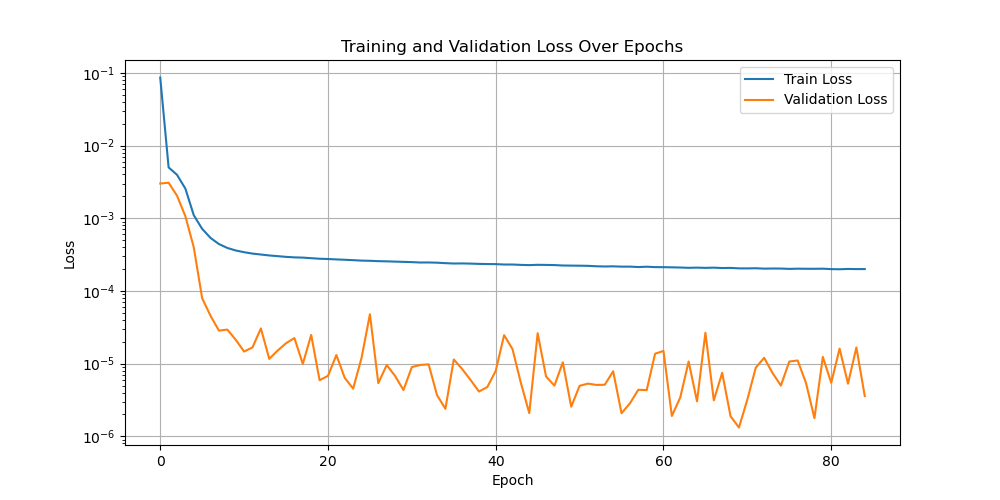

In [41]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.semilogy(history['train_loss'], label='Train Loss')
plt.semilogy(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Example usage:
def objective(trial):
    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 256, step = 16)
    num_layers = trial.suggest_int('num_layers', 2, 5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    dropout = trial.suggest_float('dropout', 0.1,0.5)
    weight_decay= trial.suggest_float('weight_decay',1e-5,1e-1, log=True)
    
    seed_len = trial.suggest_int('seed_len', 12, 128)
    pred_len = trial.suggest_int('pred_len', 1, 20)
    batch_size = trial.suggest_int('batch_size', 16, 64, step = 8)
    
    train_dataset = SequenceDataset(train_scaled, seed_len=seed_len, pred_len=pred_len)
    val_dataset = SequenceDataset(val_scaled, seed_len=seed_len, pred_len=pred_len)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    # Instantiate model with suggested hyperparameters
    model = LSTMSOH(input_dim=4, hidden_dim=hidden_size, num_layers=num_layers, dropout=dropout).type(torch.float32).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) #L2 regularization
    history, _ = train_model(model, criterion, optimizer, train_loader, val_loader)

    # Extract last validation loss
    last_val_loss = history['val_loss'][-1]
    return last_val_loss

    # Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Extract best trial
best_trial = study.best_trial
print(f"Best trial: {best_trial}")

best_hyperparams = study.best_trial.params
print('Best hyperparameters:', best_hyperparams)

In [45]:
### predict_autoregressive
def evaluate_model(model, test_loader):
    model.eval()
    # Copy the data for the specified input columns, ensuring the original df is not modified
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_test, Y_test in test_loader:
            X_test = X_test.to(device)
            Y_test = Y_test.to(device)
            batch_size, seed_len, num_features = X_test.shape
            pred_len = Y_test.shape[1]
            
            current_seq = X_test.clone()
            preds_steps = []
            
            for t in range(pred_len):
                pred = model(current_seq) 
                preds_steps.append(pred.unsqueeze(1))
                
                next_input = current_seq[:, -1, :].clone()
                
                next_input[:, 0] = pred
                current_seq = torch.cat([current_seq[:, 1:, :], next_input.unsqueeze(1)], dim=1)
            
            preds_steps = torch.cat(preds_steps, dim=1)  # (batch_size, pred_len)         
            all_preds.append(preds_steps.cpu().numpy())
            all_targets.append(Y_test.cpu().numpy())
            
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    r2 = r2_score(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    print(f"R2:{r2:.5f} | MAE: {mae:.5e}| RMSE:{rmse:.5e}")
    
    return all_preds, all_targets, r2, mae, rmse
    
all_preds, all_targets, r2, mae, rmse = evaluate_model(model, test_loader)


R2:0.99737 | MAE: 1.65564e-03| RMSE:2.04573e-03


R2:0.99737 | MAE: 1.65564e-03| RMSE:2.04573e-03


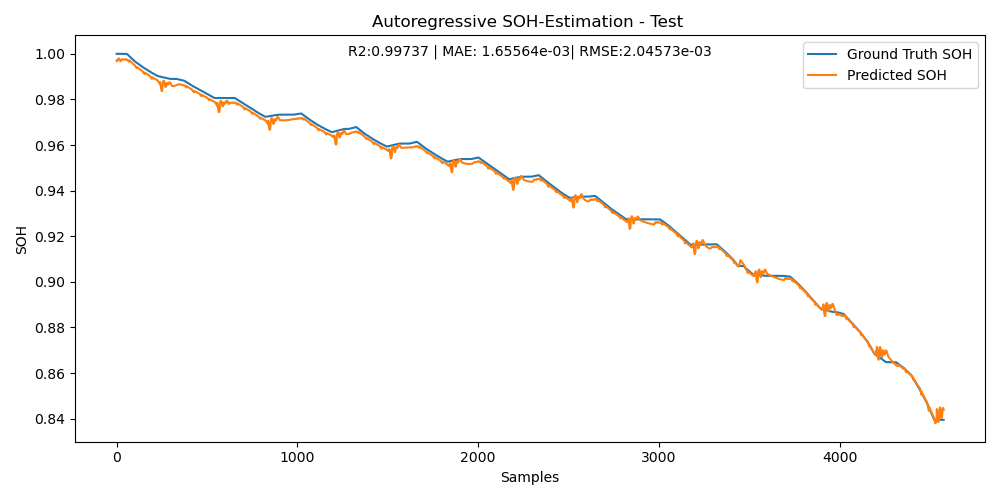

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(all_targets[:, 0], label="Ground Truth SOH")
plt.plot(all_preds[:, 0], label="Predicted SOH")
plt.title("Autoregressive SOH-Estimation - Test ")
plt.text(0.5, 0.95, f"R2:{r2:.5f} | MAE: {mae:.5e}| RMSE:{rmse:.5e}", 
         horizontalalignment='center', transform=plt.gca().transAxes)
print(f"R2:{r2:.5f} | MAE: {mae:.5e}| RMSE:{rmse:.5e}")
plt.xlabel("Samples")
plt.ylabel("SOH")
plt.legend()
plt.tight_layout()
plt.show()
